# EfficientNetB3Trained with Old and New Data


---

The Inference kernel of this notebook can be found here: https://www.kaggle.com/fanconic/efficientnetb3-inference-keras?scriptVersionId=18596729

 - LB Score: 0.786
 - Private Score: 0.910

In [1]:
# To have reproducible results and compare them
nr_seed = 11
import numpy as np 
np.random.seed(nr_seed)
import tensorflow as tf
tf.set_random_seed(nr_seed)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
# import libraries
!pip install -U '../input/install/efficientnet-0.0.3-py2.py3-none-any.whl'
import json
import math
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
import os

import cv2
from PIL import Image

import pandas as pd
import scipy
import matplotlib.pyplot as plt

from keras import backend as K
from keras import layers
from efficientnet import EfficientNetB3
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import binary_crossentropy, categorical_crossentropy
from skimage.color import rgb2hsv, lab2lch

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

warnings.filterwarnings("ignore")

%matplotlib inline

Processing /kaggle/input/install/efficientnet-0.0.3-py2.py3-none-any.whl


Using TensorFlow backend.


In [3]:
# Image size
WIDTH= 320
HEIGHT = 320
# Batch size
BATCH_SIZE = 32

# Loading & Merging

In [4]:
new_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
old_train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels_cropped.csv')
duplicates = pd.read_csv('../input/aptos-trained-weights/inconsistent.csv')
print(new_train.shape)
print(old_train.shape)
print(duplicates.shape)

(3662, 2)
(35108, 4)
(60, 1)


In [5]:
for img_name in duplicates['id_code'].values:
    new_train = new_train[new_train['id_code'] != img_name]
print(new_train.shape)

(3602, 2)


In [6]:
old_train = old_train[['image','level']]
old_train.columns = new_train.columns
old_train.diagnosis.value_counts()

# path columns
new_train['id_code'] = '../input/aptos2019-blindness-detection/train_images/' + new_train['id_code'].astype(str) + '.png'
old_train['id_code'] = '../input/diabetic-retinopathy-resized/resized_train/resized_train/' + old_train['id_code'].astype(str) + '.jpeg'

train_df = old_train.copy()
val_df = new_train.copy()
train_df.head()

,id_code,diagnosis
0,../input/diabetic-retinopathy-resized/resized_...,0
1,../input/diabetic-retinopathy-resized/resized_...,0
2,../input/diabetic-retinopathy-resized/resized_...,0
3,../input/diabetic-retinopathy-resized/resized_...,0
4,../input/diabetic-retinopathy-resized/resized_...,1


## Train - Valid split
Use new Data for validation and Old data for training£

In [7]:
# Let's shuffle the datasets
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
print(val_df.shape)

(35108, 2)
(3602, 2)


### Process Images

Crop function: https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping 

In [8]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
   
        return img


# Make all images circular (possible data loss)
def circle_crop(img):   
    """
    Create circular crop around image centre    
    """    
    
    img = crop_image_from_gray(img)    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    
    return img 

def preprocess_image(image_path, width=320, height=320, new_data=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    if new_data:
        img = crop_image_from_gray(img)
    img = cv2.resize(img, (width,height))
    #img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), 20) ,-4 ,128)

    return img

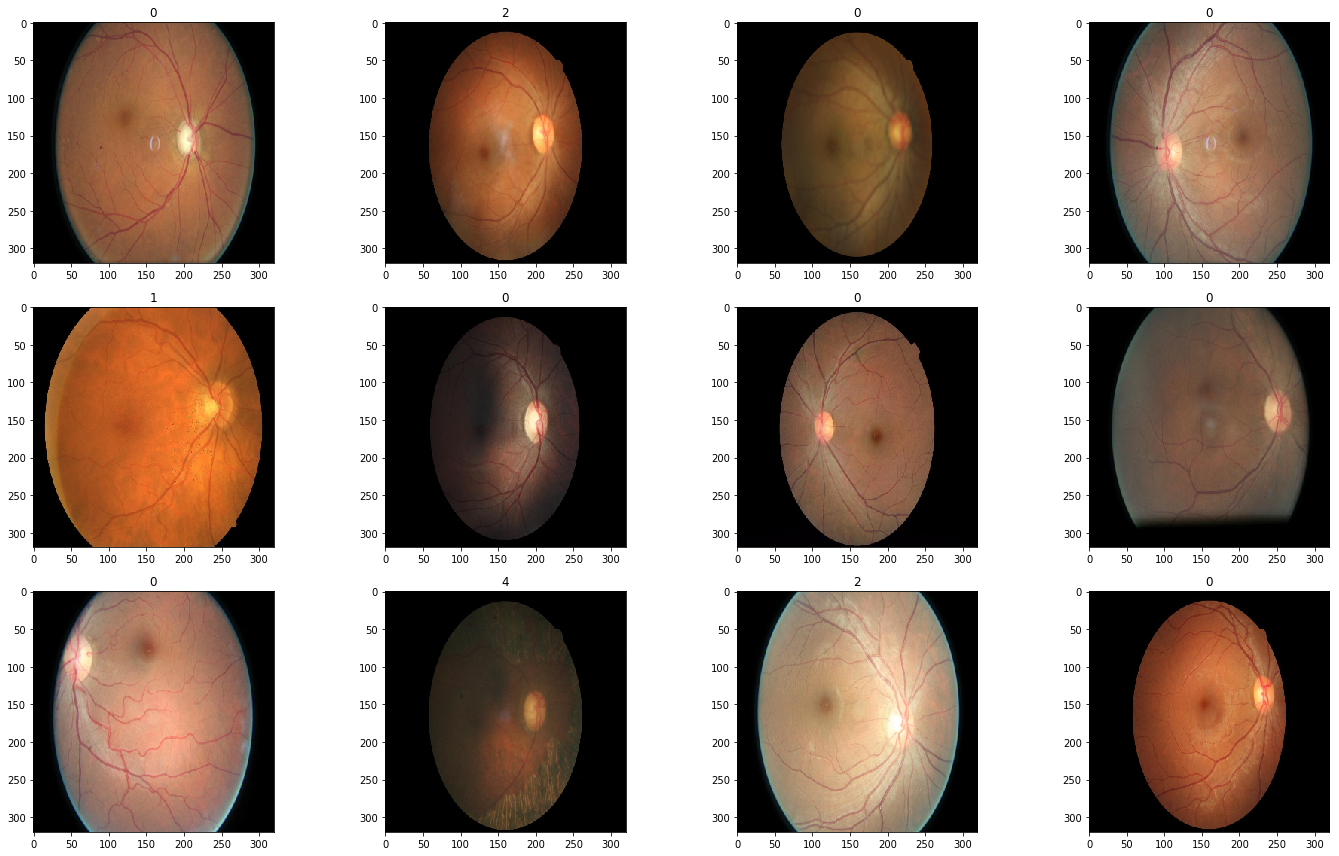

In [9]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = preprocess_image(f'{image_path}', width=WIDTH, height=HEIGHT)
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# Processing Images

__UPDATE:__ Here we are reading just the validation set. In order to use 320x320 images, we are going to load one bucket at a time only when needed. This will let our code run without memory-related errors.

In [10]:
# validation set
N = val_df.shape[0]
x_val = np.empty((N, HEIGHT, WIDTH, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm_notebook(val_df['id_code'])):
    x_val[i, :, :, :] = preprocess_image(
        f'{image_id}',
        height=HEIGHT, width=WIDTH, new_data=True
    )

In [11]:
y_train = pd.get_dummies(train_df['diagnosis']).values
y_val = pd.get_dummies(val_df['diagnosis']).values

print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(35108, 5)
(3602, 320, 320, 3)
(3602, 5)


# Creating multilabels

Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. For more details, please check out [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets).

In [12]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

y_val_multi = np.empty(y_val.shape, dtype=y_val.dtype)
y_val_multi[:, 4] = y_val[:, 4]

for i in range(3, -1, -1):
    y_val_multi[:, i] = np.logical_or(y_val[:, i], y_val_multi[:, i+1])

print("Y_train multi: {}".format(y_train_multi.shape))
print("Y_val multi: {}".format(y_val_multi.shape))

Y_train multi: (35108, 5)
Y_val multi: (3602, 5)


In [13]:
y_train = y_train_multi
y_val = y_val_multi

In [14]:
# delete the uneeded df
del new_train
del old_train
del val_df
gc.collect()

27236

# Creating keras callback for QWK

---

I had to change this function, in order to consider the best kappa score among all the buckets.

In [15]:
class Metrics(Callback):

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

# Data Generator

In [16]:
def create_datagen():
    return ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range= 0.3,
        brightness_range=(0.5, 2),
        fill_mode='constant',
        cval=0
    )

Check the differenct kinds of augmentations on the pictures.

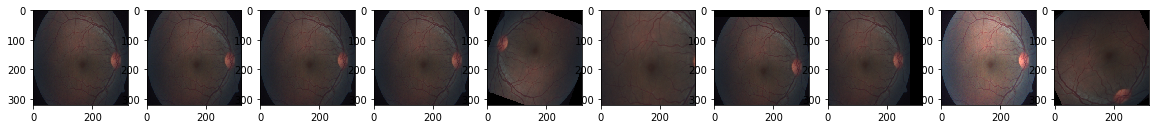

In [17]:
fig, ax = plt.subplots(1, 10, figsize=(20, 10))
ax = ax.ravel()

img = x_val[0].reshape(1,x_val[0].shape[0],x_val[0].shape[1], x_val[0].shape[2])

ax[0].imshow(img[0].astype('uint8'))
ax[1].imshow(next(ImageDataGenerator().flow(img))[0].astype('uint8'))
ax[2].imshow(next(ImageDataGenerator(horizontal_flip=True, fill_mode='constant', cval=0).flow(img))[0].astype('uint8'))
ax[3].imshow(next(ImageDataGenerator(vertical_flip=True,fill_mode='constant', cval=0).flow(img))[0].astype('uint8'))
ax[4].imshow(next(ImageDataGenerator(rotation_range=360, fill_mode='constant', cval=0).flow(img))[0].astype('uint8'))
ax[5].imshow(next(ImageDataGenerator(zoom_range= (0.65,1), fill_mode='constant', cval=0).flow(img))[0].astype('uint8'))
ax[6].imshow(next(ImageDataGenerator(height_shift_range=0.15, fill_mode='constant', cval=0).flow(img))[0].astype('uint8'))
ax[7].imshow(next(ImageDataGenerator(width_shift_range=0.15, fill_mode='constant', cval=0).flow(img))[0].astype('uint8'))
ax[8].imshow(next(ImageDataGenerator(brightness_range=(0.5, 2), fill_mode='constant', cval=0).flow(img))[0].astype('uint8'))
ax[9].imshow(next(ImageDataGenerator(horizontal_flip=True,
                                     vertical_flip=True,
                                     rotation_range=360,zoom_range= (0.65,1),
                                     brightness_range=(0.5, 2),
                                     fill_mode='constant',cval=0).flow(img))[0].astype('uint8'))


# Model: EfficientNetB3

In [18]:
efficientnetb3 = EfficientNetB3(
        weights=None,
        input_shape=(HEIGHT,WIDTH,3),
        include_top=False
                   )

efficientnetb3.load_weights("../input/efficientnet-keras-weights-b0b5/efficientnet-b3_imagenet_1000_notop.h5")

In [19]:
def build_model():
    model = Sequential()
    model.add(efficientnetb3)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        #loss=kappa_loss,
        optimizer=Adam(lr=1e-4,decay=1e-6),
        metrics=['accuracy']
    )
    
    return model

In [20]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 10, 10, 1536)      10783528  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
batch_normalization_79 (Batc (None, 1536)              6144      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 7685      
Total params: 10,797,357
Trainable params: 10,706,989
Non-trainable params: 90,368
_________________________________________________________________


# Pretraining with old Data

In [21]:
bucket_num = 8
div = round(train_df.shape[0]/bucket_num)

In [22]:
df_init = {
    'val_loss': [0.0],
    'val_acc': [0.0],
    'loss': [0.0], 
    'acc': [0.0],
    'bucket': [0.0]
}
results = pd.DataFrame(df_init)

In [23]:
# I found that changing the nr. of epochs for each bucket helped in terms of performances
epochs = [5,5,5,5,5,5,5,5]
kappa_metrics = Metrics()
kappa_metrics.val_kappas = []

learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=.2, min_lr=1e-7)

checkpoint = ModelCheckpoint('val_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [24]:
for i in range(0,bucket_num):
    if i != (bucket_num-1):
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:(1+i)*div].shape[0]
        x_train = np.empty((N, HEIGHT, WIDTH, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:(1+i)*div,0])):
            x_train[j, :, :, :] = preprocess_image(f'{image_id}', height=HEIGHT, width=WIDTH)

        data_generator = create_datagen().flow(x_train, y_train[i*div:(1+i)*div,:], batch_size=BATCH_SIZE)
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics, learn_control, checkpoint]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i
    else:
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:].shape[0]
        x_train = np.empty((N, HEIGHT, WIDTH, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:,0])):
            x_train[j, :, :, :] = preprocess_image(f'{image_id}', height=HEIGHT, width=WIDTH)
        data_generator = create_datagen().flow(x_train, y_train[i*div:,:], batch_size=BATCH_SIZE)
        
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics, learn_control, checkpoint]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i

    results = results.append(df_model)
    
    del data_generator
    del x_train
    gc.collect()
    
    print('-'*40)


Bucket Nr: 0



Epoch 1/5
138/137 [==============================] - 199s 1s/step - loss: 0.7911 - acc: 0.5458 - val_loss: 0.6236 - val_acc: 0.6599
val_kappa: 0.1755
Validation Kappa has improved. Saving model.

Epoch 00001: val_loss improved from inf to 0.62359, saving model to val_model.h5
Epoch 2/5
138/137 [==============================] - 165s 1s/step - loss: 0.6482 - acc: 0.6556 - val_loss: 0.5266 - val_acc: 0.7841
val_kappa: 0.4129
Validation Kappa has improved. Saving model.

Epoch 00002: val_loss improved from 0.62359 to 0.52661, saving model to val_model.h5
Epoch 3/5
138/137 [==============================] - 165s 1s/step - loss: 0.5266 - acc: 0.7622 - val_loss: 0.4036 - val_acc: 0.8819
val_kappa: 0.7433
Validation Kappa has improved. Saving model.

Epoch 00003: val_loss improved from 0.52661 to 0.40357, saving model to val_model.h5
Epoch 4/5
138/137 [==============================] - 165s 1s/step - loss: 0.4198 - acc: 0.8486 - val_loss: 0.3454 - val_acc: 0.8973
val_kappa: 0.7772
Validation


Epoch 1/5
138/137 [==============================] - 168s 1s/step - loss: 0.2953 - acc: 0.9005 - val_loss: 0.3478 - val_acc: 0.8994
val_kappa: 0.8221
Validation Kappa has improved. Saving model.

Epoch 00001: val_loss did not improve from 0.33828
Epoch 2/5
138/137 [==============================] - 165s 1s/step - loss: 0.2592 - acc: 0.9110 - val_loss: 0.2445 - val_acc: 0.9139
val_kappa: 0.8299
Validation Kappa has improved. Saving model.

Epoch 00002: val_loss improved from 0.33828 to 0.24448, saving model to val_model.h5
Epoch 3/5
138/137 [==============================] - 166s 1s/step - loss: 0.2381 - acc: 0.9151 - val_loss: 0.2285 - val_acc: 0.9137
val_kappa: 0.8186

Epoch 00003: val_loss improved from 0.24448 to 0.22847, saving model to val_model.h5
Epoch 4/5
138/137 [==============================] - 166s 1s/step - loss: 0.2230 - acc: 0.9207 - val_loss: 0.2359 - val_acc: 0.9119
val_kappa: 0.8281

Epoch 00004: val_loss did not improve from 0.22847
Epoch 5/5
138/137 [==============


Epoch 1/5
138/137 [==============================] - 167s 1s/step - loss: 0.2194 - acc: 0.9182 - val_loss: 0.1939 - val_acc: 0.9291
val_kappa: 0.8282

Epoch 00001: val_loss improved from 0.21814 to 0.19386, saving model to val_model.h5
Epoch 2/5
138/137 [==============================] - 166s 1s/step - loss: 0.2042 - acc: 0.9233 - val_loss: 0.1898 - val_acc: 0.9314
val_kappa: 0.8203

Epoch 00002: val_loss improved from 0.19386 to 0.18975, saving model to val_model.h5
Epoch 3/5
138/137 [==============================] - 166s 1s/step - loss: 0.1959 - acc: 0.9282 - val_loss: 0.1900 - val_acc: 0.9300
val_kappa: 0.8602
Validation Kappa has improved. Saving model.

Epoch 00003: val_loss did not improve from 0.18975
Epoch 4/5
138/137 [==============================] - 166s 1s/step - loss: 0.1844 - acc: 0.9305 - val_loss: 0.1755 - val_acc: 0.9359
val_kappa: 0.8208

Epoch 00004: val_loss improved from 0.18975 to 0.17545, saving model to val_model.h5
Epoch 5/5
138/137 [=========================


Epoch 1/5
138/137 [==============================] - 168s 1s/step - loss: 0.1995 - acc: 0.9234 - val_loss: 0.1781 - val_acc: 0.9354
val_kappa: 0.8193

Epoch 00001: val_loss did not improve from 0.17545
Epoch 2/5
138/137 [==============================] - 165s 1s/step - loss: 0.1892 - acc: 0.9267 - val_loss: 0.1814 - val_acc: 0.9363
val_kappa: 0.8596

Epoch 00002: val_loss did not improve from 0.17545
Epoch 3/5
138/137 [==============================] - 166s 1s/step - loss: 0.1853 - acc: 0.9292 - val_loss: 0.1964 - val_acc: 0.9314
val_kappa: 0.8666
Validation Kappa has improved. Saving model.

Epoch 00003: val_loss did not improve from 0.17545
Epoch 4/5
138/137 [==============================] - 166s 1s/step - loss: 0.1806 - acc: 0.9307 - val_loss: 0.1785 - val_acc: 0.9380
val_kappa: 0.8467

Epoch 00004: val_loss did not improve from 0.17545
Epoch 5/5
138/137 [==============================] - 165s 1s/step - loss: 0.1729 - acc: 0.9341 - val_loss: 0.1954 - val_acc: 0.9284
val_kappa: 0.8


Epoch 1/5
138/137 [==============================] - 168s 1s/step - loss: 0.1972 - acc: 0.9258 - val_loss: 0.1687 - val_acc: 0.9363
val_kappa: 0.8753
Validation Kappa has improved. Saving model.

Epoch 00001: val_loss improved from 0.17545 to 0.16869, saving model to val_model.h5
Epoch 2/5
138/137 [==============================] - 166s 1s/step - loss: 0.1858 - acc: 0.9306 - val_loss: 0.1920 - val_acc: 0.9190
val_kappa: 0.8642

Epoch 00002: val_loss did not improve from 0.16869
Epoch 3/5
138/137 [==============================] - 165s 1s/step - loss: 0.1817 - acc: 0.9304 - val_loss: 0.1647 - val_acc: 0.9362
val_kappa: 0.8803
Validation Kappa has improved. Saving model.

Epoch 00003: val_loss improved from 0.16869 to 0.16472, saving model to val_model.h5
Epoch 4/5
138/137 [==============================] - 166s 1s/step - loss: 0.1729 - acc: 0.9319 - val_loss: 0.1706 - val_acc: 0.9329
val_kappa: 0.8766

Epoch 00004: val_loss did not improve from 0.16472
Epoch 5/5
138/137 [==============


Epoch 1/5
138/137 [==============================] - 168s 1s/step - loss: 0.1848 - acc: 0.9294 - val_loss: 0.1518 - val_acc: 0.9439
val_kappa: 0.8835
Validation Kappa has improved. Saving model.

Epoch 00001: val_loss improved from 0.16472 to 0.15184, saving model to val_model.h5
Epoch 2/5
138/137 [==============================] - 166s 1s/step - loss: 0.1735 - acc: 0.9330 - val_loss: 0.2160 - val_acc: 0.9200
val_kappa: 0.8712

Epoch 00002: val_loss did not improve from 0.15184
Epoch 3/5
138/137 [==============================] - 166s 1s/step - loss: 0.1709 - acc: 0.9351 - val_loss: 0.1674 - val_acc: 0.9389
val_kappa: 0.8826

Epoch 00003: val_loss did not improve from 0.15184
Epoch 4/5
138/137 [==============================] - 166s 1s/step - loss: 0.1658 - acc: 0.9353 - val_loss: 0.1772 - val_acc: 0.9336
val_kappa: 0.8820

Epoch 00004: val_loss did not improve from 0.15184
Epoch 5/5
138/137 [==============================] - 166s 1s/step - loss: 0.1526 - acc: 0.9422 - val_loss: 0.185


Epoch 1/5
138/137 [==============================] - 168s 1s/step - loss: 0.1826 - acc: 0.9309 - val_loss: 0.1487 - val_acc: 0.9474
val_kappa: 0.8821

Epoch 00001: val_loss improved from 0.15184 to 0.14866, saving model to val_model.h5
Epoch 2/5
138/137 [==============================] - 166s 1s/step - loss: 0.1644 - acc: 0.9379 - val_loss: 0.1993 - val_acc: 0.9214
val_kappa: 0.8740

Epoch 00002: val_loss did not improve from 0.14866
Epoch 3/5
138/137 [==============================] - 166s 1s/step - loss: 0.1650 - acc: 0.9365 - val_loss: 0.1602 - val_acc: 0.9465
val_kappa: 0.8805

Epoch 00003: val_loss did not improve from 0.14866
Epoch 4/5
138/137 [==============================] - 165s 1s/step - loss: 0.1618 - acc: 0.9376 - val_loss: 0.1640 - val_acc: 0.9421
val_kappa: 0.8848
Validation Kappa has improved. Saving model.

Epoch 00004: val_loss did not improve from 0.14866
Epoch 5/5
138/137 [==============================] - 166s 1s/step - loss: 0.1567 - acc: 0.9417 - val_loss: 0.190


Epoch 1/5
138/137 [==============================] - 162s 1s/step - loss: 0.1779 - acc: 0.9315 - val_loss: 0.1629 - val_acc: 0.9403
val_kappa: 0.8845

Epoch 00001: val_loss did not improve from 0.14866
Epoch 2/5
138/137 [==============================] - 158s 1s/step - loss: 0.1686 - acc: 0.9354 - val_loss: 0.1503 - val_acc: 0.9429
val_kappa: 0.8828

Epoch 00002: val_loss did not improve from 0.14866
Epoch 3/5
138/137 [==============================] - 159s 1s/step - loss: 0.1678 - acc: 0.9367 - val_loss: 0.1696 - val_acc: 0.9308
val_kappa: 0.8784

Epoch 00003: val_loss did not improve from 0.14866
Epoch 4/5
138/137 [==============================] - 158s 1s/step - loss: 0.1571 - acc: 0.9399 - val_loss: 0.1902 - val_acc: 0.9257
val_kappa: 0.8739

Epoch 00004: val_loss did not improve from 0.14866
Epoch 5/5
138/137 [==============================] - 158s 1s/step - loss: 0.1560 - acc: 0.9390 - val_loss: 0.1769 - val_acc: 0.9401
val_kappa: 0.8750

Epoch 00005: val_loss did not improve fr

In [25]:
results = results.iloc[1:]
results['kappa'] = kappa_metrics.val_kappas
results = results.reset_index()
results = results.rename(index=str, columns={"index": "epoch"})
results

,epoch,acc,bucket,loss,lr,val_acc,val_loss,kappa
0,0,0.545442,0.0,0.791926,0.0001,0.659911,0.623592,0.175548
1,1,0.655333,0.0,0.648555,0.0001,0.784120,0.526610,0.412882
2,2,0.762944,0.0,0.526637,0.0001,0.881899,0.403574,0.743261
3,3,0.849499,0.0,0.417898,0.0001,0.897335,0.345362,0.777189
4,4,0.887192,0.0,0.339166,0.0001,0.899556,0.338282,0.817069
5,0,0.900866,1.0,0.295350,0.0001,0.899445,0.347793,0.822080
6,1,0.910438,1.0,0.260202,0.0001,0.913881,0.244477,0.829919
7,2,0.915542,1.0,0.237011,0.0001,0.913659,0.228473,0.818559
8,3,0.921149,1.0,0.220933,0.0001,0.911938,0.235859,0.828113
9,4,0.924157,1.0,0.205233,0.0001,0.916880,0.218135,0.824319


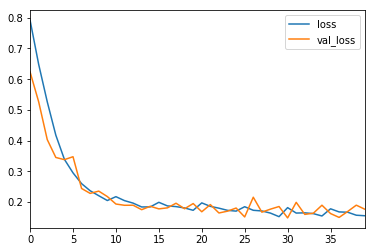

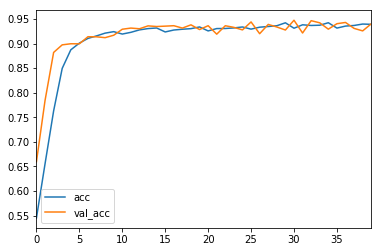

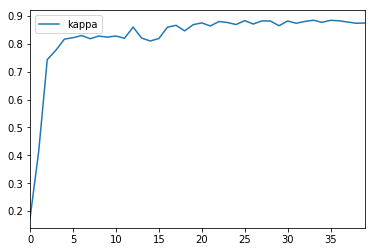

In [26]:
results[['loss', 'val_loss']].plot()
results[['acc', 'val_acc']].plot()
results[['kappa']].plot()
results.to_csv('model_results.csv',index=False)

## Fine Tune with new Data
Create New Train and Validation Set to finetune our model

In [27]:
model.load_weights('val_model.h5')

In [28]:
x_train, x_val, y_train, y_val = train_test_split(
    x_val, y_val, 
    test_size=0.2, 
    random_state=nr_seed
)

gc.collect()

7957

In [29]:
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE)

In [30]:
history = model.fit_generator(
                data_generator,
                steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                epochs=20,
                validation_data=(x_val, y_val),
                callbacks=[kappa_metrics,learn_control,checkpoint]
                )

Epoch 1/20
91/90 [==============================] - 103s 1s/step - loss: 0.2101 - acc: 0.9214 - val_loss: 0.1094 - val_acc: 0.9551
val_kappa: 0.8920
Validation Kappa has improved. Saving model.

Epoch 00001: val_loss improved from 0.14866 to 0.10935, saving model to val_model.h5
Epoch 2/20
91/90 [==============================] - 99s 1s/step - loss: 0.1382 - acc: 0.9439 - val_loss: 0.1041 - val_acc: 0.9592
val_kappa: 0.8930
Validation Kappa has improved. Saving model.

Epoch 00002: val_loss improved from 0.10935 to 0.10408, saving model to val_model.h5
Epoch 3/20
91/90 [==============================] - 99s 1s/step - loss: 0.1294 - acc: 0.9474 - val_loss: 0.1008 - val_acc: 0.9595
val_kappa: 0.8956
Validation Kappa has improved. Saving model.

Epoch 00003: val_loss improved from 0.10408 to 0.10078, saving model to val_model.h5
Epoch 4/20
91/90 [==============================] - 99s 1s/step - loss: 0.1461 - acc: 0.9463 - val_loss: 0.0963 - val_acc: 0.9637
val_kappa: 0.9077
Validation Kap

In [31]:
model.load_weights('val_model.h5')
pred_val = model.predict(x_val)

## Optimize Threshold

In [32]:
def compute_score_inv(threshold):
    y1 = pred_val > threshold
    y1 = y1.astype(int).sum(axis=1) - 1
    y2 = y_val.sum(axis=1) - 1
    score = cohen_kappa_score(y1, y2, weights='quadratic')
    return 1 - score
simplex = scipy.optimize.minimize(compute_score_inv, 0.5, method='nelder-mead')

best_threshold = simplex['x'][0]
print(best_threshold)
gc.collect()

0.46875


0